In [1]:
%%capture
!pip install numpy opencv-python matplotlib

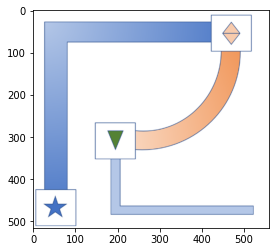

In [2]:
import cv2
import numpy as np
import math
from matplotlib import pyplot as plt
def imshow(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()
def cartesian_distance(x, y): return math.sqrt(x**2+y**2)

frame = cv2.imread("Picture1.png")
# frame = imutils.resize(frame, height=1000)
imshow(frame)

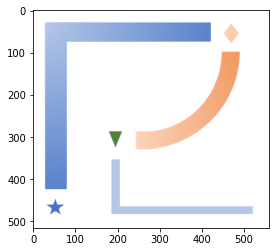

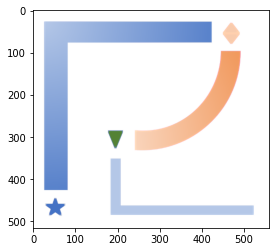

In [3]:
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
LUV = cv2.cvtColor(frame, cv2.COLOR_BGR2LUV)
blur = cv2.GaussianBlur(gray, (5, 5), 0)
kernel = np.ones((5,5),np.uint8)
dilation = cv2.dilate(frame,kernel,iterations = 1)
erosion = cv2.erode(dilation,kernel,iterations = 1)
imshow(dilation)
imshow(erosion)

Found 6contours.


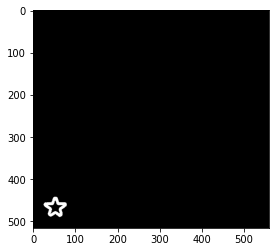

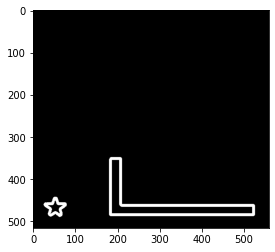

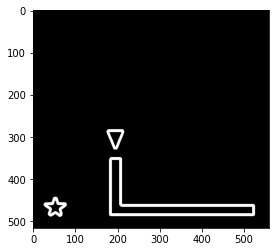

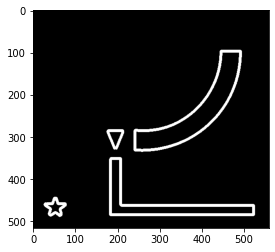

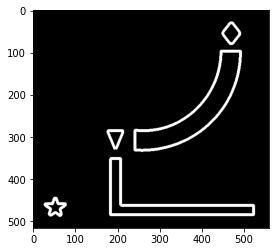

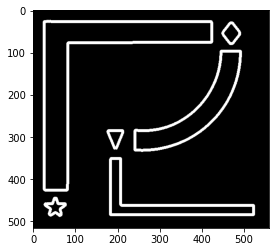

In [4]:
edges = cv2.Canny(erosion, 20, 100)
contours, hierarchy = cv2.findContours(edges,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
black = np.zeros(frame.shape[:2], dtype="uint8") # For visualize card border
print("Found " + str(len(contours)) + "contours.")
for i in range(len(contours)): # Draw each contours
    cv2.drawContours(black, contours, i, 255, 6)
    imshow(black)

In [5]:
### Filter Out Noise Contours Here ###
# rect = cv2.boundingRect(c)
# if rect[2] < 100 or rect[3] < 100: continue # Size checking

In [6]:
class Object:
    _isPath = None
    def __init__(self, contours):
        self.contours = contours
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        self.rect = np.asarray(approx, dtype = "float32")
        M = cv2.moments(c)
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        self.center = (cX, cY)
    def mask(self, *args):
        if len(args) !=0 : [source] = args
        else: source = frame
        mask = np.zeros(source.shape[:2], dtype="uint8")
        mask = cv2.fillPoly(mask, [self.contours], 255)
        return mask
    def image(self, *args):
        if len(args) !=0 : [source] = args
        else: source = frame
        rect = cv2.boundingRect(self.contours)
        x, y, w, h = rect
        return source[y:y+h, x:x+w]
    def image_part(self, *args):
        if len(args) !=0 : [source] = args
        else: source = frame
        rect = cv2.boundingRect(self.contours)
        x, y, w, h = rect
        mask = np.zeros(source.shape[:2], dtype="uint8")
        mask = cv2.fillPoly(mask, [self.contours], 255)
        masked = cv2.bitwise_and(source, source, mask=mask)
        return masked[y:y+h, x:x+w]

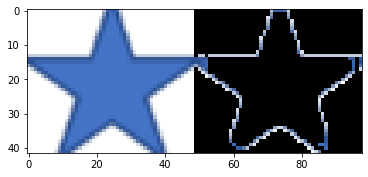

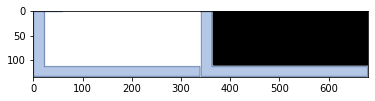

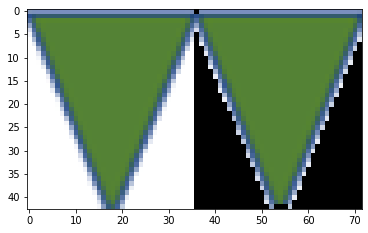

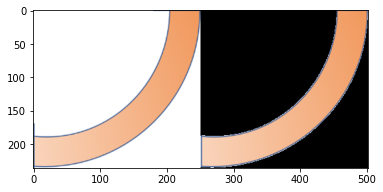

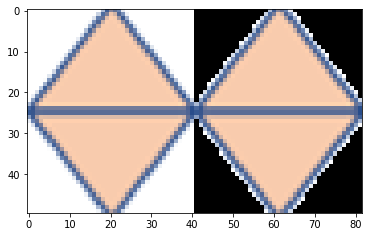

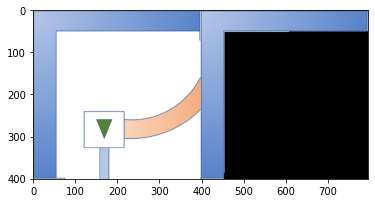

In [7]:
## Create Object ##
objects = []
for c in contours: objects.append(Object(c))
## Visualize ##
for o in objects: imshow(np.hstack((o.image(), o.image_part())))

In [93]:
class Unicorn:
    def __init__(self):
        self.objects = []
        self.objects_sorted = []
        self.marker_first = None
        self.markers_raw = []
        self.path_raw = []
        self.marker_sorted = []
        self.path_sorted = []
        self.source = frame
    def load(self, objects):
        self.objects = objects
        self.marker_first = self.near_corner() # Auto find first marker (assumed to be near corner)
    def near_corner(self): # Return object nearest to corner
        (h, w) = self.source.shape[:2]
        centers = [marker.center for marker in self.objects]
        distances = [] ## Find distance from corner to center of object
        for center in centers:
            dis_x = min(center[0], w-center[0])
            dis_y = min(center[1], h-center[1])
            distances.append(cartesian_distance(dis_x, dis_y))
        index_start = np.argmin(distances) # return index of minimum distance
        return self.objects[index_start]
    def sort_object(self):
        present = self.marker_first
        self.objects_sorted.append(present)
        while len(self.objects) != len(self.objects_sorted):
            candidates = list(filter(lambda x: x not in self.objects_sorted, self.objects)) # Unsorted objects
            
            for o in candidates:
                distance, point = self.minDistance(present.contours, o.contours)
                print(distance)
                imshow(cv2.circle(cv2.bitwise_or(present.mask(), o.mask()), point, 3, [255,102,0], 2), )
                
#             o_s = sorted(candidates, key=lambda o: self.minDistance(present.contours, o.contours))
#             o_s_img = []
#             for o in o_s:
#                 o_s_img.append(o.mask())
#                 distance, point = self.minDistance(present.contours, o.contours)
#             imshow(cv2.circle(present.mask(), point, 3, [255,102,0], 2))
#             imshow(np.concatenate(o_s_img, axis=1))
            
            present = sorted(candidates, key=lambda o: self.minDistance(present.contours, o.contours))[0]

            self.objects_sorted.append(present)
        return self.objects_sorted
    def minDistance(self, contour1, contour2):
        distanceMin = 99999999
        point = None
        for A in contour1:
            for x, y in A:
                distance = abs(cv2.pointPolygonTest(contour2, (x, y), True))
                if (distance < distanceMin):
                    distanceMin = distance
                    point = (x, y)
        return distanceMin, point
    def imshow(self, mode):
        if mode.lower() == "raw":
            o_img = []
            for o in self.objects: o_img.append(o.mask())
            imshow(np.concatenate(o_img, axis=1))
        elif mode.lower() == "sorted":
            o_img = []
            for o in self.objects_sorted: o_img.append(o.mask())
            imshow(np.concatenate(o_img, axis=1))

107.0


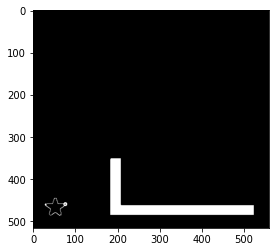

175.64168070250295


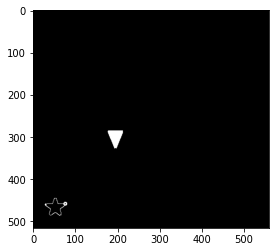

208.21623375712088


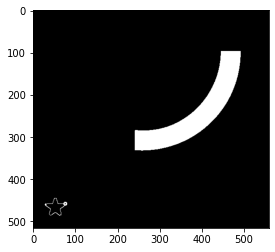

543.8207425245934


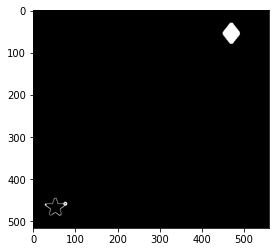

19.0


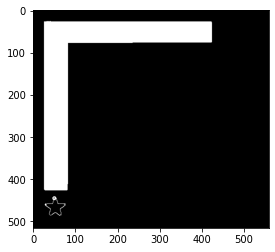

101.0


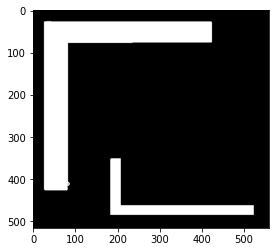

95.0


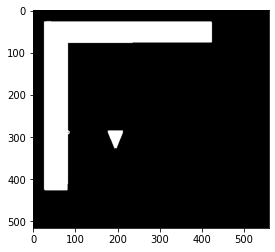

31.11269837220809


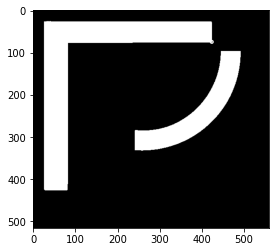

26.0


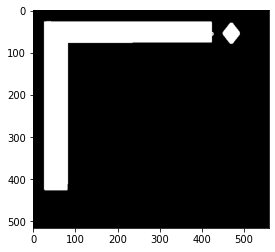

375.5862084794914


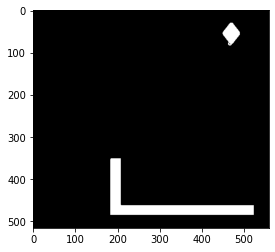

327.0351663047875


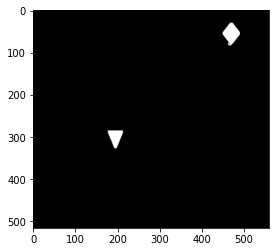

18.0


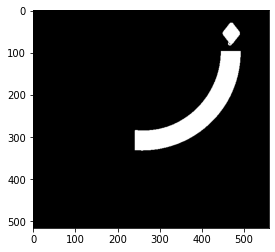

39.44616584663204


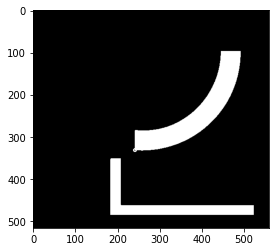

29.0


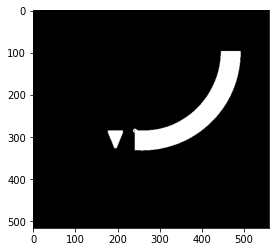

24.0


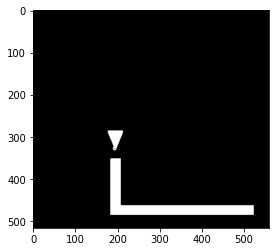

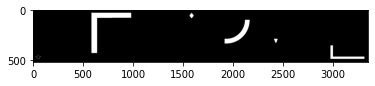

In [94]:
unicorn = Unicorn()
unicorn.load(objects)
# imshow(unicorn.marker_first.image()) ## Check first marker
unicorn.sort_object()
unicorn.imshow('sorted')